# Classifiers using neuro-imaging data

In [1]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

## Data Pre-Processing

In [2]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [5]:
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
adni2 = img_adni2.loc[img_adni2['VISCODE2'] == "sc"]
adni3 = img_adni3.loc[img_adni3['VISCODE2'] == "sc"]
adni1 = img_adni1.loc[img_adni1['VISCODE'] == 'bl']

In [6]:
#CVs = []
SVs = []
#SAs = []
#TSs = []
TAs = []
#HSs = []

for col in adni2.columns:
    
    #if col.endswith('CV'):
        #CVs.append(col)
    if col.endswith('SV'):
        SVs.append(col)
    """
    if col.endswith('SA'):
        SAs.append(col)
    if col.endswith('TS'):
        TSs.append(col)
    if col.endswith('HS'):
        HSs.append(col)
    """
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
TAs2.append("VISCODE")
TAs.append("VISCODE2")


In [7]:
dxbl_subset = dx.loc[:,["VISCODE", "VISCODE2", "RID", "DXCHANGE","DXCURREN","DIAGNOSIS", "PTID"]].copy()
imgdx2 = pd.merge(adni2.loc[:,TAs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx3 = pd.merge(adni3.loc[:,TAs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx1 = pd.merge(adni1.loc[:,TAs2].copy(), dxbl_subset, on=["RID", "VISCODE"])

In [8]:
imgdx2["PTID"].append(imgdx3['PTID'].append(imgdx1['PTID'])).nunique()

1598

In [9]:

imgdx2.loc[(imgdx2["DXCHANGE"] == 1) | (imgdx2["DXCHANGE"] == 4) |(imgdx2["DXCHANGE"] == 6), 'DXCHANGE'] = 1
imgdx2.loc[(imgdx2["DXCHANGE"] == 2) | (imgdx2["DXCHANGE"] == 5) |(imgdx2["DXCHANGE"] == 7), 'DXCHANGE'] = 2
imgdx2.loc[(imgdx2["DXCHANGE"] == 3) | (imgdx2["DXCHANGE"] == 8) |(imgdx2["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [10]:
imgdx1

,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,...,ST97TA,ST98TA,ST99TA,RID,VISCODE,VISCODE2,DXCHANGE,DXCURREN,DIAGNOSIS,PTID
0,2.187,2.617,2.357,2.301,2.346,1.492,1.711,2.335,2.228,2.147,...,1.889,2.201,2.573,15,bl,bl,NaN,1.0,NaN,100_S_0015
1,2.423,2.960,2.378,2.499,2.363,1.612,2.033,2.574,2.604,2.325,...,1.901,2.387,2.788,86,bl,bl,NaN,1.0,NaN,136_S_0086
2,2.287,2.536,2.303,2.881,2.305,1.463,1.909,2.858,2.382,2.248,...,1.988,2.414,2.740,184,bl,bl,NaN,1.0,NaN,136_S_0184
3,2.004,2.372,2.294,2.168,2.018,1.713,1.672,1.991,2.108,1.898,...,1.809,2.168,2.139,187,bl,bl,NaN,2.0,NaN,032_S_0187
4,1.979,1.897,2.244,2.272,2.085,1.327,1.784,2.132,2.196,1.946,...,1.764,2.063,2.379,190,bl,bl,NaN,3.0,NaN,100_S_0190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2.308,2.118,2.485,2.508,2.433,1.776,1.954,2.403,2.412,2.260,...,2.129,2.345,2.736,1326,bl,bl,NaN,2.0,NaN,016_S_1326
108,2.232,2.753,2.544,2.412,2.324,1.789,1.891,2.445,2.306,2.172,...,2.067,2.597,2.570,1331,bl,bl,NaN,2.0,NaN,051_S_1331
109,2.058,2.255,2.191,2.166,2.209,1.499,1.779,2.412,1.991,2.218,...,1.814,2.419,2.642,1337,bl,bl,NaN,3.0,NaN,130_S_1337
110,2.347,2.445,2.550,2.475,2.165,1.961,1.833,2.221,2.201,2.169,...,2.040,2.335,2.768,1338,bl,bl,NaN,2.0,NaN,051_S_1338


In [11]:
imgdx1.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)
imgdx2.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)
imgdx3.drop(["VISCODE", "VISCODE2", "PTID", "RID"], inplace=True, axis=1)

img = imgdx1.append(imgdx2.append(imgdx3))

In [12]:
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCHANGE'])
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCURREN'])
img.drop(['DXCURREN', 'DXCHANGE'], axis=1, inplace=True)

In [13]:
img.columns

Index(['ST102TA', 'ST103TA', 'ST104TA', 'ST105TA', 'ST106TA', 'ST107TA',
       'ST108TA', 'ST109TA', 'ST110TA', 'ST111TA', 'ST113TA', 'ST114TA',
       'ST115TA', 'ST116TA', 'ST117TA', 'ST118TA', 'ST119TA', 'ST121TA',
       'ST129TA', 'ST130TA', 'ST13TA', 'ST14TA', 'ST15TA', 'ST23TA', 'ST24TA',
       'ST25TA', 'ST26TA', 'ST31TA', 'ST32TA', 'ST34TA', 'ST35TA', 'ST36TA',
       'ST38TA', 'ST39TA', 'ST40TA', 'ST43TA', 'ST44TA', 'ST45TA', 'ST46TA',
       'ST47TA', 'ST48TA', 'ST49TA', 'ST50TA', 'ST51TA', 'ST52TA', 'ST54TA',
       'ST55TA', 'ST56TA', 'ST57TA', 'ST58TA', 'ST59TA', 'ST60TA', 'ST62TA',
       'ST72TA', 'ST73TA', 'ST74TA', 'ST82TA', 'ST83TA', 'ST84TA', 'ST85TA',
       'ST90TA', 'ST91TA', 'ST93TA', 'ST94TA', 'ST95TA', 'ST97TA', 'ST98TA',
       'ST99TA', 'DIAGNOSIS'],
      dtype='object')

In [14]:

data = img
data_sane = data[data['DIAGNOSIS'] !=3].mean(axis=0)
stddev_sane = data[data['DIAGNOSIS'] !=3].std(axis=0)
data_alz = data[data['DIAGNOSIS'] == 3].mean(axis=0)

In [15]:
data_sane - data_alz

ST102TA      0.054250
ST103TA      0.242794
ST104TA      0.086035
ST105TA      0.094299
ST106TA      0.056793
               ...   
ST95TA       0.093075
ST97TA       0.072315
ST98TA       0.059556
ST99TA       0.203466
DIAGNOSIS   -1.522207
Length: 69, dtype: float64

## Alzheimer's classifier

Here, we wish to creater a classifier that is able to distinguish patients which have dementia/alzheimer's from patients that either have MCI or do not have any problem.
This classifier uses cross sectional brain imaging data.

### Feature selection

<Axes: xlabel='DIAGNOSIS', ylabel='Count'>

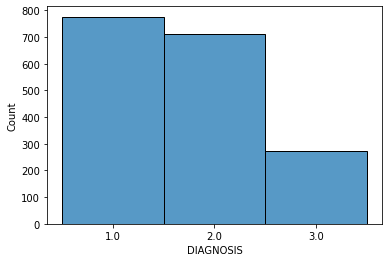

In [17]:
sns.histplot(img['DIAGNOSIS'].astype(str))

In [29]:
img.dropna(inplace=True)
Y = img['DIAGNOSIS']
X = img.drop(['DIAGNOSIS'], axis=1)
Y.loc[Y == 1] = 0
Y.loc[Y == 2] = 0
Y.loc[Y == 3] = 1


### Model training

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, train_size=0.6)

### Cross-validation

In [32]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]

In [34]:
kfold = KFold(n_splits=10)
for model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='balanced_accuracy', n_jobs=-1)
    print(model, cv_results.sum()/10)

GradientBoostingClassifier() 0.6623577208776712
RandomForestClassifier() 0.6727885931160147
SVC() 0.6453974397572317
DecisionTreeClassifier() 0.6520877878719771
MLPClassifier() 0.6423257638790268


### Evaluation

## Evolution Predictor

Here we are trying to predict whether a patient currently experiencing MCI will get alzheimer's in the future from cross-sectionnal neuroimaging data. Researchers have found that having a MCI multiplies a patient's chances of developing Alzheimer's in the future. Around 20 to 20% of people with MCI develop dementia in under a year.
This is the reason why we are trying to predict the evolution. If we are able to detect whether a patient is very likely to get alzheimer's in under 2 years then it will be easier to help the patient.